# Range Compression
In this notebook we perform range compression of raw SHARAD radargrams following the pipeline used by the Italian SHARAD team. For information on the processing steps, see calinfo.txt within the Mars ODE SHARAD product folder.
The notebook is only for educational purpose and may contain errors. A faster and clean version of range compression is provided in the src folder.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

c = 299792458

In [3]:
# Load raw data eventually obtained from concatenation
raw_data = np.load('/Users/jordy/Data/SHARAD/SAR/raw_data.npy')[:,:]
print('(Samples,Rangelines)',raw_data.shape)

(Samples,Rangelines) (3600, 78780)


In [4]:
# Decompression
presum = 4
bps = 8
raw_data = raw_data*2**(np.round(np.log2(presum))-bps+8)/presum
raw_data = raw_data-raw_data.mean()

In [5]:
samples, rangelines = raw_data.shape
sf = 80e6/3 # 80/3 MHz sampling frequency

In [6]:
# Topographic Shift. Topography has been obtained from ancillary files
topo = np.load('/Users/jordy/Data/SHARAD/SAR/topo.npy') * 1000 # in meters
topo = topo - topo.min()
print('Mean topography diff [km]', topo.mean())

# Sampling freq is 80/3 MHz -> dt = 3/80e6 s
# space = v * t = 3e8 * 3/80e6 s
dz = c/np.sqrt(3.15) * (1/sf) # Space within ice travelled by EM pulse in 1/SF seconds
print('dz [m]:', dz)

pixel_topo = topo/dz # Topographic shift in pixels
print('Mean pixel shift:',pixel_topo.mean())

# Shifting each row by topo shift in pixels
for i in range(raw_data.shape[1]):
    raw_data[:,i] = np.roll(raw_data[:,i], shift = -int(np.round(pixel_topo[i])))


Mean topography diff [km] 979.6589146594948
dz [m]: 6.334271785355503
Mean pixel shift: 154.66006951650127


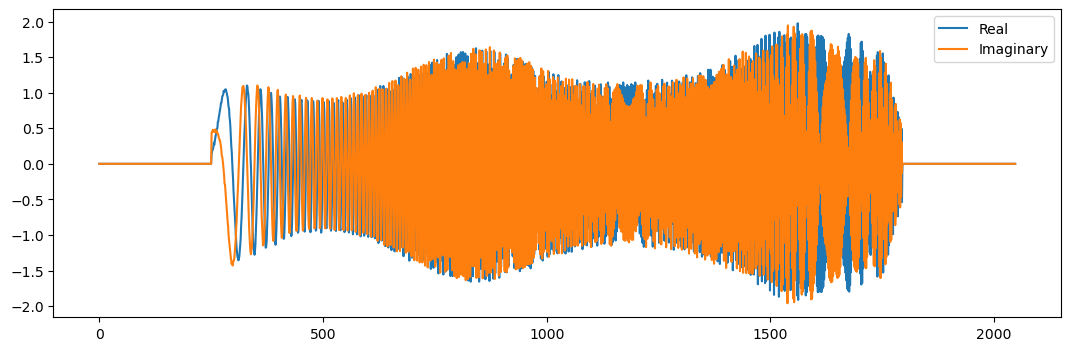

In [7]:
# Chirp
# Loading chirp as per SHARAD docs. One shoudl select the best chirp according to TX and RX temperatures.
chirpf = '/Users/jordy/Data/SHARAD/SAR/reference_chirp_p60tx_p20rx.dat'
POINTS = 2048
C = np.zeros((2,POINTS)) # first row is real, second row is imaginary
with open(chirpf, 'rb') as fid:
    C[0,:] = np.fromfile(fid, dtype='<f4', count=POINTS, offset= 0)
with open(chirpf, 'rb') as fid:
    C[1,:] = np.fromfile(fid, dtype='<f4', count=POINTS, offset= POINTS*4) #4 bytes per item

plt.figure(1, figsize = (13,4))
plt.plot(C[0,:])
plt.plot(C[1,:])
plt.legend(['Real','Imaginary'])

chirp = C[0,:] + 1j*C[1,:] # This is the spectrum of the chirp

In [8]:
# Pad raw data to nearest power of 2
to_pad = np.zeros((248, rangelines))
raw_data = np.concatenate([to_pad, raw_data, to_pad], axis = 0)
print('Padded raw data dimension:', raw_data.shape)

Padded raw data dimension: (4096, 78780)


In [9]:
# Time interval of the pulse sampled at SF
T = 1/sf*raw_data.shape[0]
t_signal = np.linspace(0,T-1/sf, raw_data.shape[0])
print(t_signal.shape)

(4096,)


In [14]:
raw_data_complex = raw_data * np.exp(2*np.pi*(80/3 - 20)*1j*t_signal)[:,np.newaxis] # Complex demodulation
signal_fft = np.fft.fft(raw_data_complex, axis = 0)                                      # Signal FFT
signal_fft = signal_fft[1024:3072,:]                                                     # Keep only signal central frequencies
chirp_conj = np.fft.fftshift(np.conjugate(chirp))                                        # Chirp spectrum conjugate
range_compressed_fft = chirp_conj[:,np.newaxis]*signal_fft                               # Multiplication between Signal FFT and Chirp spectrum conjugate

In [15]:
# Without Hann windowing there is much degradation in the range compressed product
hann_window = np.hanning(range_compressed_fft.shape[0])[:,np.newaxis]
range_compressed_windowed = range_compressed_fft*np.fft.fftshift(hann_window)
range_compressed = np.fft.ifft(range_compressed_windowed, axis = 0)

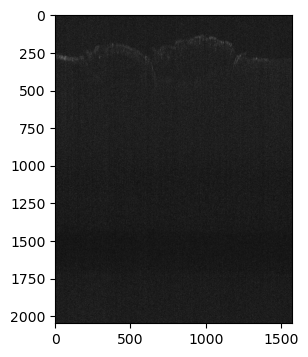

In [16]:
plt.figure(figsize = (13,4))
plt.imshow(np.abs(range_compressed[:,::50]), cmap = 'gray')

In [22]:
# Eventually sum s consecutive rangelines. s=1 means no sum (this preserves the PRF).
# Eventually plot the image in dB and save to file for further processing
plt.figure(3)
a,b = range_compressed[:,:].shape
s = 1
chunks = np.reshape(range_compressed[:,:],(a,-1,s)).sum(axis=2)
image = 20*np.log10(np.abs(chunks))
#plt.imshow(image, aspect = 'auto', cmap='grey')
#np.save("range_compressed.npy",chunks)